<b>Context</b><br>
This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

<b>Content</b><br>
The dataset contains two columns, "Sentiment" and "News Headline". The sentiment can be negative, neutral or positive.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import re
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import time

In [5]:
data = pd.read_csv(r'C:\Users\TEJKIRAN\Desktop\DataAnalytics_files\all-data.csv',encoding="latin1",header=None)
data.columns = ["Label","Text"]
data.head()

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [13]:
data["Text"][0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

<b>Step 1: Data Analyses</b>

C:\Users\TEJKIRAN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

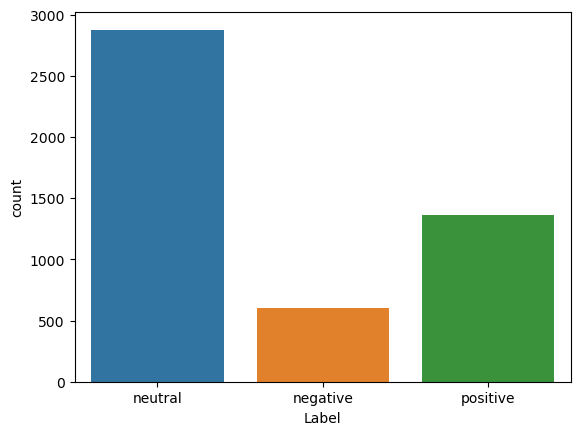

In [7]:
sns.countplot(data["Label"])

Then let's take a look at the lenghts by class.

Dataset is unbalanced, most of the dataset is neutral as we can predict.<br>
This may cause problems

In [8]:
data["len"] = [len(text) for text in data["Text"].values]

data.groupby("Label")["len"].mean()

Label
negative    125.756623
neutral     125.072247
positive    135.647836
Name: len, dtype: float64

In [9]:
data

,Label,Text,len
0,neutral,"According to Gran , the company has no plans t...",127
1,neutral,Technopolis plans to develop in stages an area...,190
2,negative,The international electronic industry company ...,228
3,positive,With the new production plant the company woul...,206
4,positive,According to the company 's updated strategy f...,203
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,144
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,148
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,108
4844,negative,Net sales of the Paper segment decreased to EU...,226


As we can see length of sentences are unrelated with classes.

<b>Step 2: Cleaning Texts</b>

In this section we'll clean the texts, in order to clean texts we will define a function.

In [17]:
def cleantext(text):
    lemma = WordNetLemmatizer()
    stp = stopwords.words('english')
    
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    text = text.lower()
    
    text = nltk.word_tokenize(text)
    
    text = [lemma.lemmatize(word) for word in text if word not in stp]
    
    text = " ".join(text)
    return text

In [18]:
cleantext("Nowadays I am interested in traditional text feature extraction methods, because I want to learn foundations")

'nowadays interested traditional text feature extraction method want learn foundation'

In [20]:
start_time = time.time()
cleanedText = []
for text in data["Text"]:
    
    cleanedText.append(cleantext(text))
end_time = time.time()
process_time = round(end_time-start_time,2)

print("="*10)
print("Texts are cleaned, this process took {} seconds \n \n".format(process_time))

print(cleanedText[0])

Texts are cleaned, this process took 2.3 seconds 
 

according gran company plan move production russia although company growing


In [22]:
data["Label"].value_counts()

neutral     2879
positive    1363
negative     604
Name: Label, dtype: int64

In [25]:
y = []
for label in data["Label"]:
    
    if label=="negative":
        y.append(0)
        
    elif label=="positive":
        y.append(2)
        
    elif label=="neutral":
        y.append(1)

y = np.asarray(y)

In [26]:
y

array([1, 1, 0, ..., 0, 0, 0])

<b>Step 3: Implementing TF-IDF Vectorizing</b>

In [29]:
# First, we need a vectorizer object
vectorizer = TfidfVectorizer(max_features=4000)
# This means just consider most used 4000 words

start = time.time()

x = vectorizer.fit_transform(cleanedText).toarray()

process_time = round(time.time()-start,2)

print("Vectorizing cleaned text using TF-IDF approach took {} seconds".format(process_time))

x.shape

Vectorizing cleaned text using TF-IDF approach took 0.12 seconds


(4846, 4000)

In [31]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3876, 4000)
(970, 4000)
(3876,)
(970,)


In [32]:
x[0]

array([0., 0., 0., ..., 0., 0., 0.])

<b>Step 4: Building and Training Adaboost Classifier</b>

In [35]:
# We'll use 100 weak learners to build a strong learner
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=50)

classifier.fit(x_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

Test set accuracy of our Adaboost Classifier is 72.58


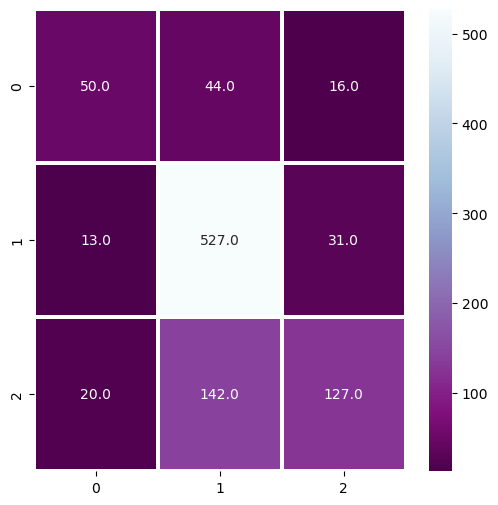

In [36]:
y_pred = classifier.predict(x_test)

print("Test set accuracy of our Adaboost Classifier is {}".format(round(accuracy_score(y_pred,y_test)*100,2)))

plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix(y_pred=y_pred,y_true=y_test),annot=True,fmt=".1f",linewidths=1.5,cmap="BuPu_r")
plt.show()

Because of our dataset is unbalanced we could'nt train our classifier great.    

<b>Step 5: Saving Model and Defining Test Function</b>

In this section we'll save model and vectorizer using pickle object serialization and write a function that takes text as parameter and returns sentiment (neutral,positive,negative)

In [37]:
pickle.dump(classifier,open("adaboost.pickle","wb"))
pickle.dump(vectorizer,open("vectorizer.pickle","wb"))

In [40]:
def analyseText(text):
    
    cls = pickle.load(open("adaboost.pickle","rb"))
    vct = pickle.load(open("vectorizer.pickle","rb"))
    
    # First we need to clean the text given
    text = cleantext(text)
    
    # Then we need to vectorize the text
    text = vct.transform([text])
    
    # And let's predict results using vector
    pred = cls.predict(text)
    
    decision = "neutral"
    
    if pred[0] == 0:
        decision = "negative"
        
    elif pred[0] == 2:
        decision = "positive"
        
    return decision

In [41]:
analyseText("Rental of building equipment accounted for 88 percent of the operating income ")

'neutral'

In [42]:
analyseText("O'Leary 's Material Handling Services , located in Perth , is the leading company in Western Australia that supplies , installs and provides service for tail lifts .")

'positive'